In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import os
import os.path
from fcmeans import FCM
from sklearn.cluster import KMeans


In [48]:
def plot_images(img_stack, *, labels=None, figdim=5, colormap=plt.cm.gray, show=True, **imshowkwarg):
    """
    Funzione di utilità per mostrare una grigli di immagini, impostando la lista delle legende
    e, opzionalmente, la colormap che di default è impostata a livelli di grigio
    """    
    nimag = len(img_stack)

    # creiamo il layout
    nrows = 1 if nimag <= 3 else 2 if nimag <= 6 else 3 if nimag <=12 else 4 if nimag <= 16 else 5
    ncols = nimag if nrows == 1 else 2 if nimag == 4 else 3 if nimag <=9 else 4 if nimag <= 16 else 5

    # generiamo la figura con un canvas ce riserva 5x5 pollici a immagine
    # e i riferimenti alle singole immagini
    fig, axs = plt.subplots(nrows,ncols,squeeze=False,figsize=(figdim*ncols, figdim*nrows))
    
    img = 0 # contatore delle immagini

    for r in range(nrows):
        for c in range(ncols):
            # eliminiamo lo stile del grafico
            axs[r, c].tick_params(axis='both',\
                    which='both',\
                    bottom=False,top=False,right=False,left=False,\
                    labelbottom=False,labelleft=False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['bottom'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)

            # se ci troviamo nella posizione di una
            # immagine allora la mostriamo
            if r*ncols + c < nimag:
                if labels != None:
                    axs[r, c].set_title(labels[img])
            
                axs[r, c].imshow(img_stack[img], cmap=colormap, **imshowkwarg)

                img += 1 # immagine successiva
    
    if show == True:
        plt.show()
    
    return axs

def load_dcm_volume(directory):
    """
    Funzione che carica un volume di dati DICOM da una cartella
    assumendo che questa contenga solamente un insieme di file .dcm
    
    La funzione restituisce anche la stringa con la modalità diagnostica e
    gli eventuali parametri della trasformazione della dinamica in HU
    """

    # parametri del header DICOM
    modality = ''
    slope = 0.0
    intercept = 0.0
    
    # leggiamo la lista dei file nella cartella
    files = os.listdir(directory)
    files.sort()
    
    # leggiamo il primo file per ottenere le dimensioni e il tipo della singola slice
    file = pydicom.dcmread(f'{directory}/{files[0]}')
    
    # Leggiamo le informazioni del header DICOM
    modality = file.Modality
    
    if modality == 'CT':
        slope = float(file.RescaleSlope)
        intercept = float(file.RescaleIntercept)
    
    # creiamo il volume
    volume = np.full((len(files),file.pixel_array.shape[0],file.pixel_array.shape[1]),\
                    1,dtype=file.pixel_array.dtype)

    # carichiamo la prima slice, già letta, e successivamente le altre 
    volume[0,:,:] = file.pixel_array

    for i in range(1,len(files)):
        volume[i,:,:] = pydicom.dcmread(f'{directory}/{files[i]}').pixel_array
    
    vol = np.copy(volume)

    if file.SeriesDescription != '' and file.SeriesDescription.find('Sag') != -1:
        vol=np.reshape(vol,(volume.shape[1],volume.shape[2],volume.shape[0]))

        for i in range(volume[:,0,:].shape[1]):
            vol[i,:,:] = volume[:,i,:].T
    
    if file.SeriesDescription != '' and file.SeriesDescription.find('Cor') != -1:
        vol=np.reshape(vol,(volume.shape[1],volume.shape[0],volume.shape[2]))

        for i in range(volume[:,0,:].shape[0]):
            vol[i,:,:] = volume[:,i,:]
    
    return (modality, slope, intercept, vol)

windows = {'lung': {'level': -700, 'width': 1000},
            'soft': {'level': 50, 'width': 400},
            'bone': {'level': 400, 'width': 1800},
            'liver': {'level': 30, 'width': 150}}

In [49]:
def projection(volume, mode='mip', direction='coronal', alpha=None):

    if mode == 'composite' and type(alpha) != np.ndarray:

        raise(ValueError('an alpha array must be defined with values in [0, 1], and the same shape as volume'))

    axis = 1 if direction == 'coronal' else 0 if direction == 'axial' else 2

    shape = (volume.shape[0] if axis != 0 else volume.shape[1],\
            volume.shape[1] if axis ==2 else volume.shape[2])
    
    proj = np.zeros(shape=shape,dtype='float')

    if mode == 'mip':
        proj = np.max(volume,axis=axis)
    
    elif mode == 'minip':
        proj = np.min(volume, axis=axis)
        
    elif mode == 'avg':
            proj = np.average(volume,axis=axis)
        
    elif mode == 'composite':
        
        for i in range(shape[0]):
            for j in range(shape[1]):
                
                row = volume[i,:,j] if axis ==1\
                    else volume[i,j,:] if axis == 2 else volume[:,i,j]
                c = 0
                for k in np.arange(alpha.shape[axis]-1,-1,-1):
                    
                    a = alpha[i, j, k] if axis == 2\
                        else alpha[k, i, j] if axis == 0 else alpha[i, k, j]
                    c = (1 - a)*c + a*row[k]
                    
                proj[i, j] = c
    
    return proj

In [50]:
def transfer_function(window, vmin, vmax):
    
    alpha = np.zeros((vmax-vmin+1,),dtype=float)
    
    c = window['level'] - vmin # segue l'indicizzazione del vettore alpha che ha solo
                               # indici positivi
    
    # controlliamo se i punti di corner del nostro profilo trapezoidale
    # eccedono la dinamica vmin -- vmax
    lower = np.max([0,c - window['width'] // 2])
    upper = np.min([c + window['width']//2,vmax - vmin])
    
    corner1 = np.max([0,c - window['width'] // 4])
    corner2 = np.min([c + window['width']//4,vmax - vmin])
    
    alpha[corner1:corner2] = 1                          # base minore del trapezio
    
    if lower != corner1:                                # lato ascendente
        alpha[lower:corner1] = np.linspace(0,1,corner1-lower)
    
    if upper != corner2:                                # lato discendente
        alpha[corner2:upper] = np.linspace(1,0,upper-corner2)
    
    return alpha
    

In [51]:
(modality, slope, intercept, vol) = load_dcm_volume('Data/series-00000/')

if modality == 'CT':
        ct_scan = vol*slope + intercept
else:
    ct_scan = vol

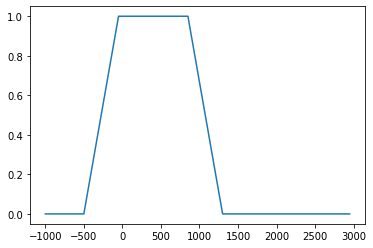

In [67]:
min_ct = int(np.min(ct_scan))
max_ct = int(np.max(ct_scan))

tf = transfer_function(windows['bone'],min_ct, max_ct)

plt.plot(np.arange(min_ct,max_ct+1),tf)
plt.show()

In [63]:
# creiamo il volume di trasparenza secondo una finestra prefissata in HU

def make_alpha_volume(tran_fun, volume):
    
    alpha_vol = np.zeros(volume.shape, dtype=float)
    
    min_vol = int(np.min(volume))
    
    for i in range(volume.shape[0]):
        for j in range(volume.shape[1]):
            for k in range(volume.shape[2]):
                alpha_vol[i,j,k] = tran_fun[int(volume[i,j,k]) - min_vol]
    
    return alpha_vol
    

In [68]:
alpha = make_alpha_volume(tf,ct_scan)

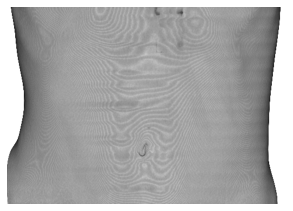

In [70]:

ct_proj = projection(ct_scan,mode='composite',direction='coronal',alpha=alpha)
axes = plot_images([ct_proj])

In [71]:
brain_info = load_dcm_volume('Data/Sag_FLAIR+FATSAT_CUBE_3')

In [80]:
brain = brain_info[3]

flat_brain = brain.reshape((brain.shape[0]*brain.shape[1]*brain.shape[2],1))

flat_brain.shape

(8912896, 1)

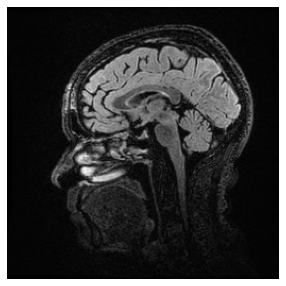

In [73]:
ax = plot_images([brain[:,:,68]])

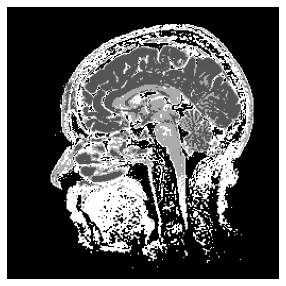

In [81]:
num_clusters = 4

fcm_brain = FCM(n_clusters=num_clusters)
fcm_brain.fit(flat_brain)
fcm_brain_labels = fcm_brain.predict(flat_brain)

brain_clustered = fcm_brain_labels.reshape(brain.shape)
axes = plot_images([brain_clustered[:,:,68]])

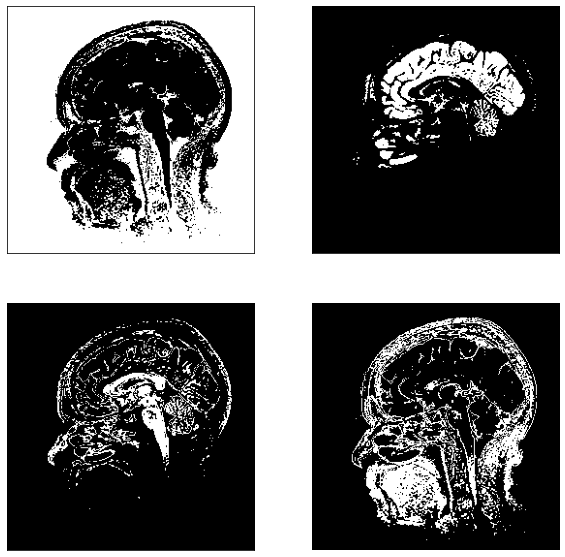

In [82]:
clusters = np.full((num_clusters,brain.shape[0],brain.shape[1],brain.shape[2]),0)

for i in range(num_clusters):
    clusters[i] = np.where(brain_clustered == i, 1, 0)

axes = plot_images(clusters[:,:,:,68])

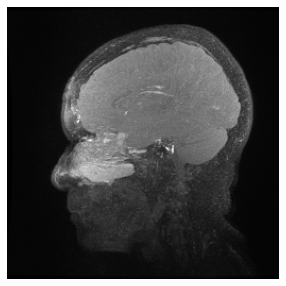

In [85]:
p = projection(brain,direction='sagittal',mode='mip',alpha=clusters[1])

ax = plot_images([p])